## Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## Set GPU Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Create Folder Structures

In [12]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Positives and Anchors

## Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [156]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [13]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## Collect Positive and Anchor Classes

In [14]:
# Import uuid library to generate unique image names
import uuid

In [15]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\deea3991-8864-11ef-b1f0-387a0ea814b0.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    #Cut down frame to 250x250px
    frame = frame[200:200+250,230:230+250,:]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
         
# Release the webcamqq
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

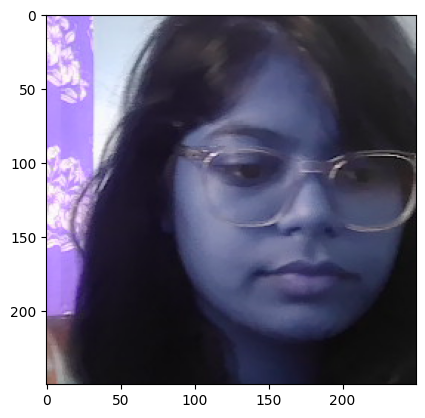

In [178]:
plt.imshow(frame)

# Load and Preprocess Images

## Get Image Directories

In [16]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\\*.jpg').take(300)

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data\\anchor\\62e81161-82df-11ef-9742-387a0ea814b0.jpg'


## Preprocessing - Scale and Resize

In [19]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [184]:
img = preprocess('data\\anchor\\525efc3a-82df-11ef-b38a-387a0ea814b0.jpg')

In [185]:
img.numpy().max() 

1.0

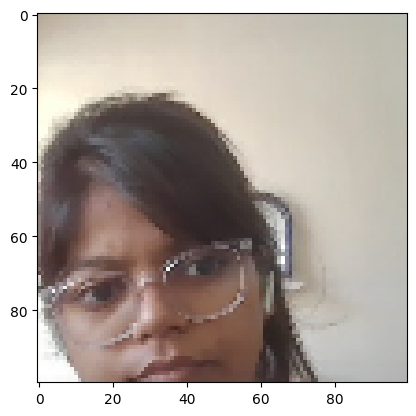

In [186]:
plt.imshow(img)

## Create Labelled Dataset

In [187]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [20]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [21]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [22]:
samples = data.as_numpy_iterator()

In [23]:
example = samples.next()

In [24]:
example

(b'data\\anchor\\502885a2-82df-11ef-949f-387a0ea814b0.jpg',
 b'data\\positive\\b18748b8-8623-11ef-a5dc-387a0ea814b0.jpg',
 1.0)

## Build Train and Test Partition

In [29]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [30]:
res = preprocess_twin(*example)

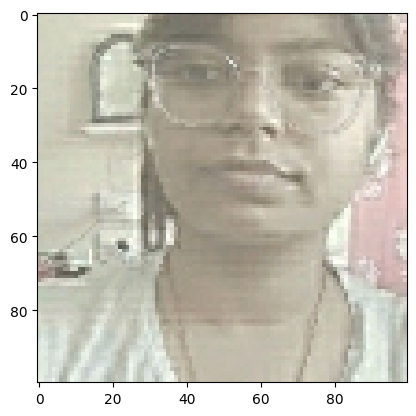

In [32]:
plt.imshow(res[1])

In [33]:
res[2]

1.0

In [34]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [35]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [36]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [37]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

## Build Embedding Layer

In [38]:
inp = Input(shape=(100,100,3), name='input_image')

In [39]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [40]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [41]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [42]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [43]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [44]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [45]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 100, 100, 3)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d (Conv2D)               │ (None, 91, 91, 64)    │       19,264 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 46, 46, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)             │ (None, 40, 40, 128)   │      401,536 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_1               │ (None, 20, 20, 128)   │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 17, 17, 128)   │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_2               │ (None, 9, 9, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_3 (Conv2D)             │ (None, 6, 6, 256)     │      524,544 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten (Flatten)             │ (None, 9216)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 4096)          │   37,752,832 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [47]:
embedding = make_embedding()

In [48]:
embedding.summary()


Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_image (InputLayer)      │ (None, 100, 100, 3)   │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_4 (Conv2D)             │ (None, 91, 91, 64)    │       19,264 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_3               │ (None, 46, 46, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_5 (Conv2D)             │ (None, 40, 40, 128)   │      401,536 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_4               │ (None, 20, 20, 128)   │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_6 (Conv2D)             │ (None, 17, 17, 128)   │      262,272 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_5               │ (None, 9, 9, 128)     │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_7 (Conv2D)             │ (None, 6, 6, 256)     │      524,544 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten_1 (Flatten)           │ (None, 9216)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)               │ (None, 4096)          │   37,752,832 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## Build Distance Layer

In [49]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
    def call(self, inputs):
        # inputs will be a list containing both embeddings
        input_embedding, validation_embedding = inputs
        return tf.math.abs(input_embedding - validation_embedding)

# Define input tensors
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

# Get embeddings
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

# Instantiate the custom layer and compute distances
siamese_layer = L1Dist()
distances = siamese_layer([inp_embedding, val_embedding])


In [214]:
l1=L1Dist()

## Make Siamese Model

In [50]:
classifier = Dense(1, activation='sigmoid')(distances)

In [51]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [52]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_img          │ (None, 100, 100, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ validation_img     │ (None, 100, 100, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ embedding          │ (None, 4096)     │ 38,960,4… │ input_img[0][0], │
│ (Functional)       │                  │           │ validation_img[… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ l1_dist (L1Dist)   │ (None, 4096)     │         0 │ embedding[0][0], │
│                    │                  │           │ embedding[1][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dense_2 (Dense)    │ (None, 1)        │     4,097 │ l1_dist[0][0]    │
└────────────────────┴──────────────────┴───────────┴──────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer([embedding(input_image), embedding(validation_image)])
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_model = make_siamese_model()

In [56]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_img          │ (None, 100, 100, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ validation_img     │ (None, 100, 100, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ embedding          │ (None, 4096)     │ 38,960,4… │ input_img[0][0], │
│ (Functional)       │                  │           │ validation_img[… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ l1_dist_1 (L1Dist) │ (None, 4096)     │         0 │ embedding[2][0], │
│                    │                  │           │ embedding[3][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dense_3 (Dense)    │ (None, 1)        │     4,097 │ l1_dist_1[0][0]  │
└────────────────────┴──────────────────┴───────────┴──────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Training

## Setup Loss and Optimizer

In [222]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [223]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## Establish Checkpoints

In [224]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build Train Step Function

In [57]:
test_batch = train_data.as_numpy_iterator()


In [58]:
batch_1 = test_batch.next()
test_batch.next()

(array([[[[0.9977941 , 0.7977941 , 0.85759807],
          [0.90367645, 0.6872549 , 0.7617647 ],
          [1.        , 0.7732843 , 0.85637254],
          ...,
          [0.72843134, 0.72843134, 0.6970588 ],
          [0.722549  , 0.722549  , 0.6852941 ],
          [0.7137255 , 0.72156864, 0.67058825]],
 
         [[0.9504902 , 0.5507353 , 0.6615196 ],
          [0.9816176 , 0.66568625, 0.7558824 ],
          [0.9394608 , 0.59607846, 0.69509804],
          ...,
          [0.73014706, 0.73014706, 0.6909314 ],
          [0.7257353 , 0.7257353 , 0.685049  ],
          [0.7176471 , 0.7254902 , 0.6745098 ]],
 
         [[0.9485294 , 0.5252451 , 0.62107843],
          [0.9252451 , 0.55857843, 0.64411765],
          [0.9125    , 0.5732843 , 0.6514706 ],
          ...,
          [0.73308825, 0.73308825, 0.6879902 ],
          [0.7286765 , 0.7286765 , 0.68210787],
          [0.72156864, 0.7235294 , 0.6754902 ]],
 
         ...,
 
         [[0.8       , 0.40122548, 0.5568628 ],
          [0.79338

In [59]:
len(batch_1[0])

16

In [60]:
X = batch_1[:2]
np.array(X).shape

(2, 16, 100, 100, 3)

In [61]:
y = batch_1[2]
y

array([0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
      dtype=float32)

In [62]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        y = tf.reshape(y, tf.shape(yhat))
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## Build Training Loop

In [63]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [64]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch{}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))  # Initialize Progba

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Perform the training step
            train_step(batch)
            # Update the progress bar
            progbar.update(idx + 1)
        # Save checkpoints every 10 epochs
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [235]:
EPOCHS = 50

In [236]:
train(train_data, EPOCHS)


 Epoch1/50
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 155s 6s/step

 Epoch2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 171s 6s/step

 Epoch3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step

 Epoch4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step

 Epoch5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step

 Epoch6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 141s 5s/step

 Epoch7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step

 Epoch8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step

 Epoch9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step

 Epoch10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step

 Epoch11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1414s 54s/step

 Epoch12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step

 Epoch13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 208s 8s/step

 Epoch14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step

 Epoch15/50
27/27 ━━━━━━━━━━━━━

# Evaluate Model

## Import Metrics

In [65]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## Make Predictions

In [66]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(test_input.shape)
print(test_val.shape)

(16, 100, 100, 3)
(16, 100, 100, 3)


In [67]:
test_var=test_data.as_numpy_iterator().next()
print(test_input.shape)
print(test_val.shape)

(16, 100, 100, 3)
(16, 100, 100, 3)


In [68]:
y_true

array([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

In [69]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.50023437],
       [0.50017226],
       [0.49987042],
       [0.49971876],
       [0.50065494],
       [0.50054336],
       [0.5001949 ],
       [0.5003257 ],
       [0.50121665],
       [0.5008246 ],
       [0.5003537 ],
       [0.5003774 ],
       [0.5000603 ],
       [0.50021654],
       [0.5000572 ],
       [0.499917  ]], dtype=float32)

In [70]:
print(test_input.shape)
print(test_val.shape)
print(y_hat.shape)

(16, 100, 100, 3)
(16, 100, 100, 3)
(16, 1)


In [71]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [72]:
y_true

array([1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

## Calculate Metrics

In [73]:
print(test_input.shape)
print(test_val.shape)
print(y_hat.shape)
print(y_true.shape)

(16, 100, 100, 3)
(16, 100, 100, 3)
(16, 1)
(16,)


In [74]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.53846157

In [75]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.53846157

In [77]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
0.7764706 0.4852941


## Viz Results

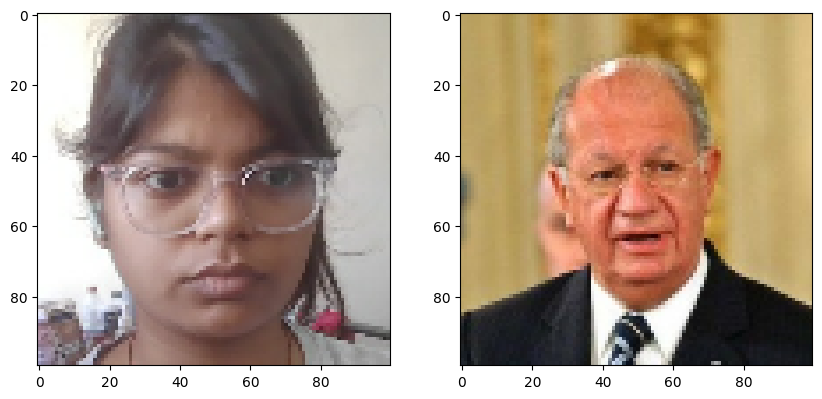

In [79]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# Save Model

In [80]:
# Save weights
siamese_model.save('siamesemodelv2.keras')

In [288]:
L1Dist

__main__.L1Dist

In [289]:
model = tf.keras.models.load_model('siamesemodelv2.keras', 
                                           custom_objects={'L1Dist': L1Dist, 
                                                           'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [290]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.1061289e-11],
       [1.9156655e-10],
       [1.0000000e+00],
       [1.5560951e-10],
       [1.0000000e+00],
       [9.1292069e-12],
       [1.0000000e+00],
       [1.6094106e-08],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.3730455e-09]], dtype=float32)

In [291]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_img          │ (None, 100, 100, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ validation_img     │ (None, 100, 100, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ embedding          │ (None, 4096)     │ 38,960,4… │ input_img[0][0], │
│ (Functional)       │                  │           │ validation_img[… │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ l1_dist_17         │ (None, 4096)     │         0 │ embedding[0][0], │
│ (L1Dist)           │                  │           │ embedding[1][0]  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ dense_10 (Dense)   │ (None, 1)        │     4,097 │ l1_dist_17[0][0] │
└────────────────────┴──────────────────┴───────────┴──────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real Time Test

## Verification Function

In [81]:
os.listdir(os.path.join('application_data', 'verification_images'))

['1a73a9de-82e5-11ef-b3ab-387a0ea814b0.jpg',
 '1a73dd91-82e5-11ef-be9b-387a0ea814b0.jpg',
 '1a73dd92-82e5-11ef-b75a-387a0ea814b0.jpg',
 '1a75421c-82e5-11ef-b448-387a0ea814b0.jpg',
 '1a75421d-82e5-11ef-a621-387a0ea814b0.jpg',
 '1a7657d5-82e5-11ef-9978-387a0ea814b0.jpg',
 '1a7657d6-82e5-11ef-a5bc-387a0ea814b0.jpg',
 '1a7657d7-82e5-11ef-9de3-387a0ea814b0.jpg',
 '1a77a654-82e5-11ef-ae5a-387a0ea814b0.jpg',
 '1a8d5ec3-82e5-11ef-b78d-387a0ea814b0.jpg',
 '1a8e9c2d-82e5-11ef-a5fb-387a0ea814b0.jpg',
 '1a8e9c2f-82e5-11ef-a2df-387a0ea814b0.jpg',
 '1a8e9c30-82e5-11ef-82dc-387a0ea814b0.jpg',
 '1a912da8-82e5-11ef-ac1a-387a0ea814b0.jpg',
 '1a92453b-82e5-11ef-966c-387a0ea814b0.jpg',
 '1aa953a3-82e5-11ef-a6ae-387a0ea814b0.jpg',
 '1aaa8dea-82e5-11ef-a6f2-387a0ea814b0.jpg',
 '1aaa8deb-82e5-11ef-98c1-387a0ea814b0.jpg',
 '1aabc664-82e5-11ef-86b1-387a0ea814b0.jpg',
 '1aabc665-82e5-11ef-82ca-387a0ea814b0.jpg',
 '1aabc666-82e5-11ef-a5ab-387a0ea814b0.jpg',
 '1aad8555-82e5-11ef-b5a6-387a0ea814b0.jpg',
 '1aad8556

In [82]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [83]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\1a73a9de-82e5-11ef-b3ab-387a0ea814b0.jpg
application_data\verification_images\1a73dd91-82e5-11ef-be9b-387a0ea814b0.jpg
application_data\verification_images\1a73dd92-82e5-11ef-b75a-387a0ea814b0.jpg
application_data\verification_images\1a75421c-82e5-11ef-b448-387a0ea814b0.jpg
application_data\verification_images\1a75421d-82e5-11ef-a621-387a0ea814b0.jpg
application_data\verification_images\1a7657d5-82e5-11ef-9978-387a0ea814b0.jpg
application_data\verification_images\1a7657d6-82e5-11ef-a5bc-387a0ea814b0.jpg
application_data\verification_images\1a7657d7-82e5-11ef-9de3-387a0ea814b0.jpg
application_data\verification_images\1a77a654-82e5-11ef-ae5a-387a0ea814b0.jpg
application_data\verification_images\1a8d5ec3-82e5-11ef-b78d-387a0ea814b0.jpg
application_data\verification_images\1a8e9c2d-82e5-11ef-a5fb-387a0ea814b0.jpg
application_data\verification_images\1a8e9c2f-82e5-11ef-a2df-387a0ea814b0.jpg
application_data\verification_images\1a8e9c30-82e5-11ef-82dc-387

In [84]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## OpenCV Real Time Verification

In [90]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [86]:
results

[array([[0.4992813]], dtype=float32),
 array([[0.49975058]], dtype=float32),
 array([[0.4997571]], dtype=float32),
 array([[0.49952352]], dtype=float32),
 array([[0.49958846]], dtype=float32),
 array([[0.49965027]], dtype=float32),
 array([[0.4998716]], dtype=float32),
 array([[0.4999607]], dtype=float32),
 array([[0.4998368]], dtype=float32),
 array([[0.49972945]], dtype=float32),
 array([[0.4998862]], dtype=float32),
 array([[0.49965394]], dtype=float32),
 array([[0.4997525]], dtype=float32),
 array([[0.49988168]], dtype=float32),
 array([[0.49990425]], dtype=float32),
 array([[0.49967027]], dtype=float32),
 array([[0.49979395]], dtype=float32),
 array([[0.4998868]], dtype=float32),
 array([[0.49992922]], dtype=float32),
 array([[0.4999726]], dtype=float32),
 array([[0.49995095]], dtype=float32),
 array([[0.49989653]], dtype=float32),
 array([[0.4999325]], dtype=float32),
 array([[0.49951896]], dtype=float32),
 array([[0.49982607]], dtype=float32),
 array([[0.49993908]], dtype=float3

In [88]:
np.sum(np.squeeze(results)<.5)

54